In [231]:
import os
import numpy as np
import muspy
from tqdm import tqdm
import config
import utils
import tarfile
import shutil
import collections
from matplotlib import pyplot as plt

config_string = "standard"

ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
conf = config.Config(config_string, ROOT_PATH)



# Warning, ~ 10 hours required

In [123]:
lmd = utils.get_dataset("lmd", conf)
maestro = utils.get_dataset("maestro", conf)
nes = utils.get_dataset("nes", conf)
# hymn = get_dataset("hymn", conf)
folk = utils.get_dataset("folk", conf)

In [124]:
print("folk: {}, maestro: {}, nes: {}, tot: {}".format(
    len(folk), 
    len(maestro), 
    len(nes), 
    len(folk)+len(maestro)+len(nes)))


folk: 1033, maestro: 1276, nes: 5278, tot: 7587


---
## Data exploration

In [125]:
dataset = lmd

In [126]:
print(len(dataset))
flag = False
for i in tqdm(range(len(dataset))):

    # check if same instrument is used multiple times
    # if collections.Counter(np.unique(list(track.program for track in dataset[i].tracks)))  \
    #     != collections.Counter(list(track.program for track in dataset[i].tracks)):
    #     print(i)
    
    # check if there are key_signatures
    # if len(k_signs := dataset[i].key_signatures) > 1: 
    #     print(k_signs)
    #     print(i)

    # if len(t_signs := dataset[i].time_signatures) > 1: 
    #     print(t_signs)
    #     print(i)

    # if len(tempo := dataset[i].tempos) > 1: 
    #     print(tempo)
    #     print(i)

    # for track in dataset[i].tracks:
    #     if track.is_drum:
    #         print(i)
    pass

174533


100%|██████████| 174533/174533 [00:00<00:00, 4531071.61it/s]


In [127]:
dataset[0].tracks[0].notes[0]

Note(time=0, pitch=78, duration=120, velocity=127)

In [129]:
stats = {
    "n_tracks" : np.zeros(1000),            # how many instruments are playing in a song (can also be 2 of the same instrument)
    "programs" : np.zeros(1000),             # which type of instrument
    "pitch": np.zeros(500),
    "velocity" : np.zeros(128),             # how loud (0-127)
    "durations": {},          # how many quarters does the note last(?)
    "drum_durations": {},
    "tempos": [],                           # how fast is the song in qpm (quarters per minute) --> can be non integer
    "time_signatures": {},                  # 4/4 or 3/4 etc... store it as a dict
    "key_signatures": {},        # which is the main key
    "len_notes": [],
    "len_drums": []
}

for song in tqdm(dataset):

    resolution = song.resolution
    # how many tracks are in the song (tracks = different "instrument voices" but could be 4 pianos)
    stats["n_tracks"][len(song)] += 1 
    

    # how many different instruments and which
    programs = np.unique(list(track.program for track in song.tracks))  
    for program in programs:
        stats["programs"][program] += 1


    # stats on key signatures
    key_signatures = list(set((key_sign.root, key_sign.mode) for key_sign in song.key_signatures)) 

    for key_sign in key_signatures:
        if key_sign in stats["key_signatures"].keys():
            stats["key_signatures"][key_sign] += 1
        else:
            stats["key_signatures"][key_sign] = 1


    # stats on time_signatures --> need to know which exist / are used to create possible tokens
    time_signatures = list(set((time_sign.numerator, time_sign.denominator) for time_sign in song.time_signatures)) 

    for time_sign in time_signatures:
        if time_sign in stats["time_signatures"].keys():
            stats["time_signatures"][time_sign] += 1
        else:
            stats["time_signatures"][time_sign] = 1

    # stats on tempos
    tempos = list(set(tempo.qpm for tempo in song.tempos))

    for tempo in tempos:
        stats["tempos"].append(tempo)

    # notes
    tot_notes = 0
    tot_drums = 0
    for track in song.tracks:

        if len(track) > 0:
            stats["programs"][track.program] += 1

            if track.is_drum:
                tot_drums += len(track.notes)

                for note in track.notes:

                    stats["pitch"][note.pitch + 128] += 1
                    stats["velocity"][note.velocity] += 1
                    
                    # duration / resolution = duration in beath lengths
                    if (dur := note.duration / resolution) in stats["drum_durations"].keys():
                        stats["drum_durations"][dur] += 1
                    else:
                        stats["drum_durations"][dur] = 1
            else:
                tot_notes += len(track.notes)

                for note in track.notes:
                    stats["pitch"][note.pitch] += 1
                    stats["velocity"][note.velocity] += 1

                    # duration / resolution = duration in beath lengths
                    if (dur := note.duration / resolution) in stats["durations"].keys():
                        stats["durations"][dur] += 1
                    else:
                        stats["durations"][dur] = 1

    stats["len_notes"].append(tot_notes)
    stats["len_drums"].append(tot_drums)

        


100%|██████████| 174533/174533 [59:38<00:00, 48.78it/s] 


In [236]:
def plot_scatter_limit(a, lim=0):
    plt.scatter(range(len(a[:lim])), np.sort(a)[:lim]);


def plot_bar_centered(a, lim=None):
    min_idx = len(a)
    max_idx = 0
    for i, n in enumerate(list(a)):
        if n>0:
            if i < min_idx:
                min_idx = i
            if i > max_idx:
                max_idx = i

    plt.figure(figsize=(26,5))
    if lim != None:
        plt.bar(range(len(a[lim[0]:lim[1]])), a[lim[0]:lim[1]])
        plt.xticks(ticks=range(0,lim[1]-lim[0]), labels=range(lim[0], lim[1]), rotation=90);
        print("The remaining not shown values amount to {:.2f}% of the total".format((sum(a[lim[1]:])+sum(a[:lim[0]]))/sum(a)*100))
    else:
        plt.bar(range(len(a[min_idx:max_idx])), a[min_idx:max_idx])
        plt.xticks(ticks=range(0,max_idx-min_idx), labels=range(min_idx, max_idx), rotation=90);


def plot_scatter_from_dict(d, lim_percentage=0, mapping=None):

    if mapping == None:
        mapping = lambda x: x
    tot = np.sum(list(d.values()))
    arr = np.zeros((len(d.keys()), 2))
    for i, key in enumerate(d.keys()):
        arr[i,0] = mapping(key)
        arr[i,1] = d[key]/tot*100

    plt.scatter([x[0] for x in arr if x[1] > lim_percentage], [x[1] for x in arr if x[1] > lim_percentage])
    print("The remaining not shown values amount to {:.2f}% of the total".format(sum([x[1] for x in arr if x[1] <= lim_percentage])/sum(arr[:,1])*100))


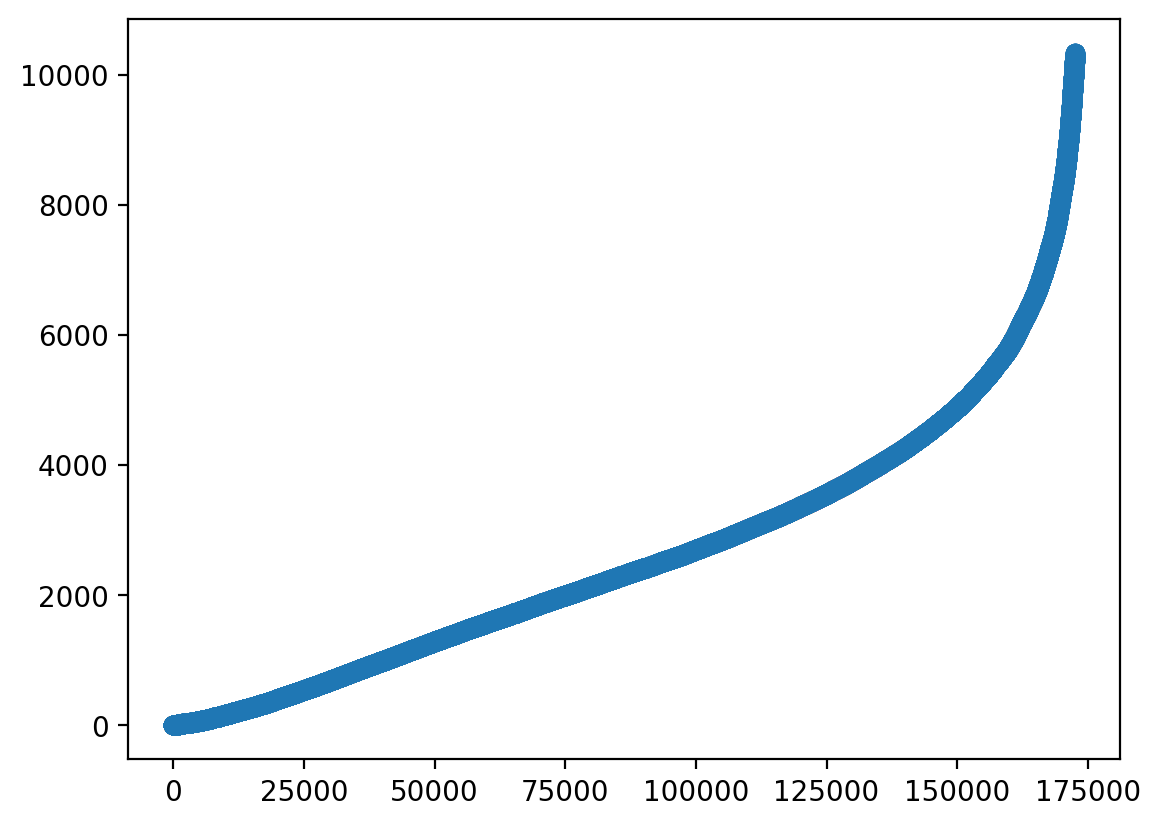

In [187]:
plot_scatter_limit(stats["len_notes"], lim=-2000)

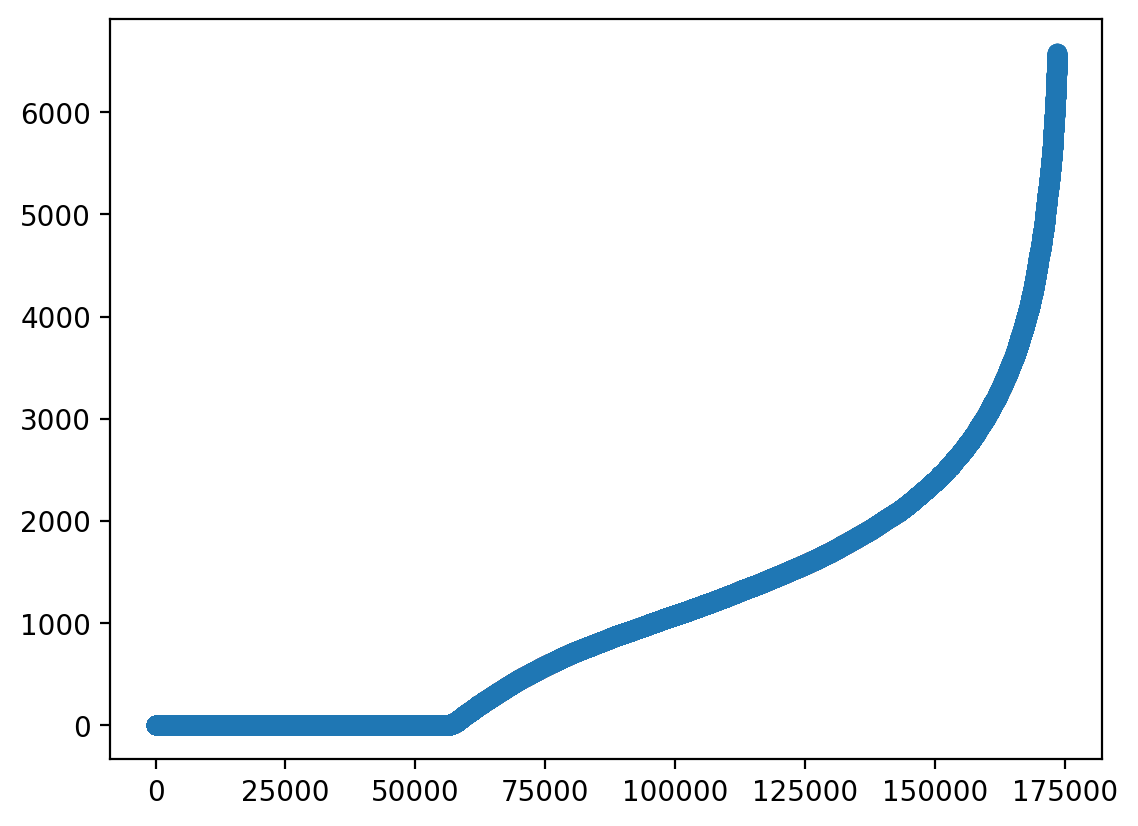

In [188]:
plot_scatter_limit(stats["len_drums"], lim=-1000)

The remaining not shown values amount to 0.14% of the total


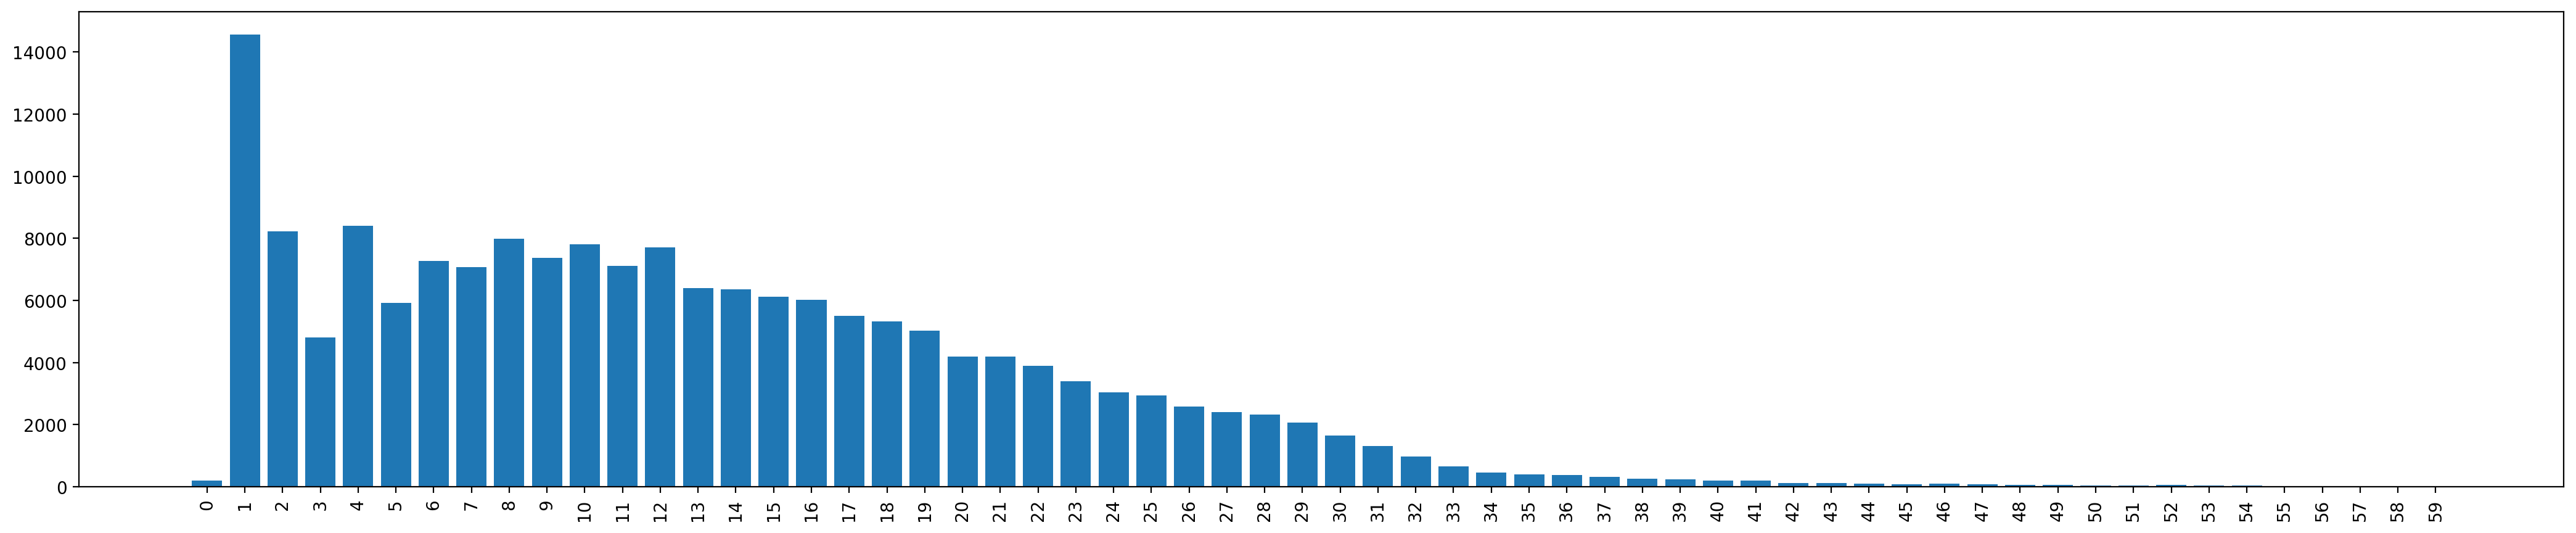

In [207]:
plot_bar_centered(stats["n_tracks"], lim=[0, 60])

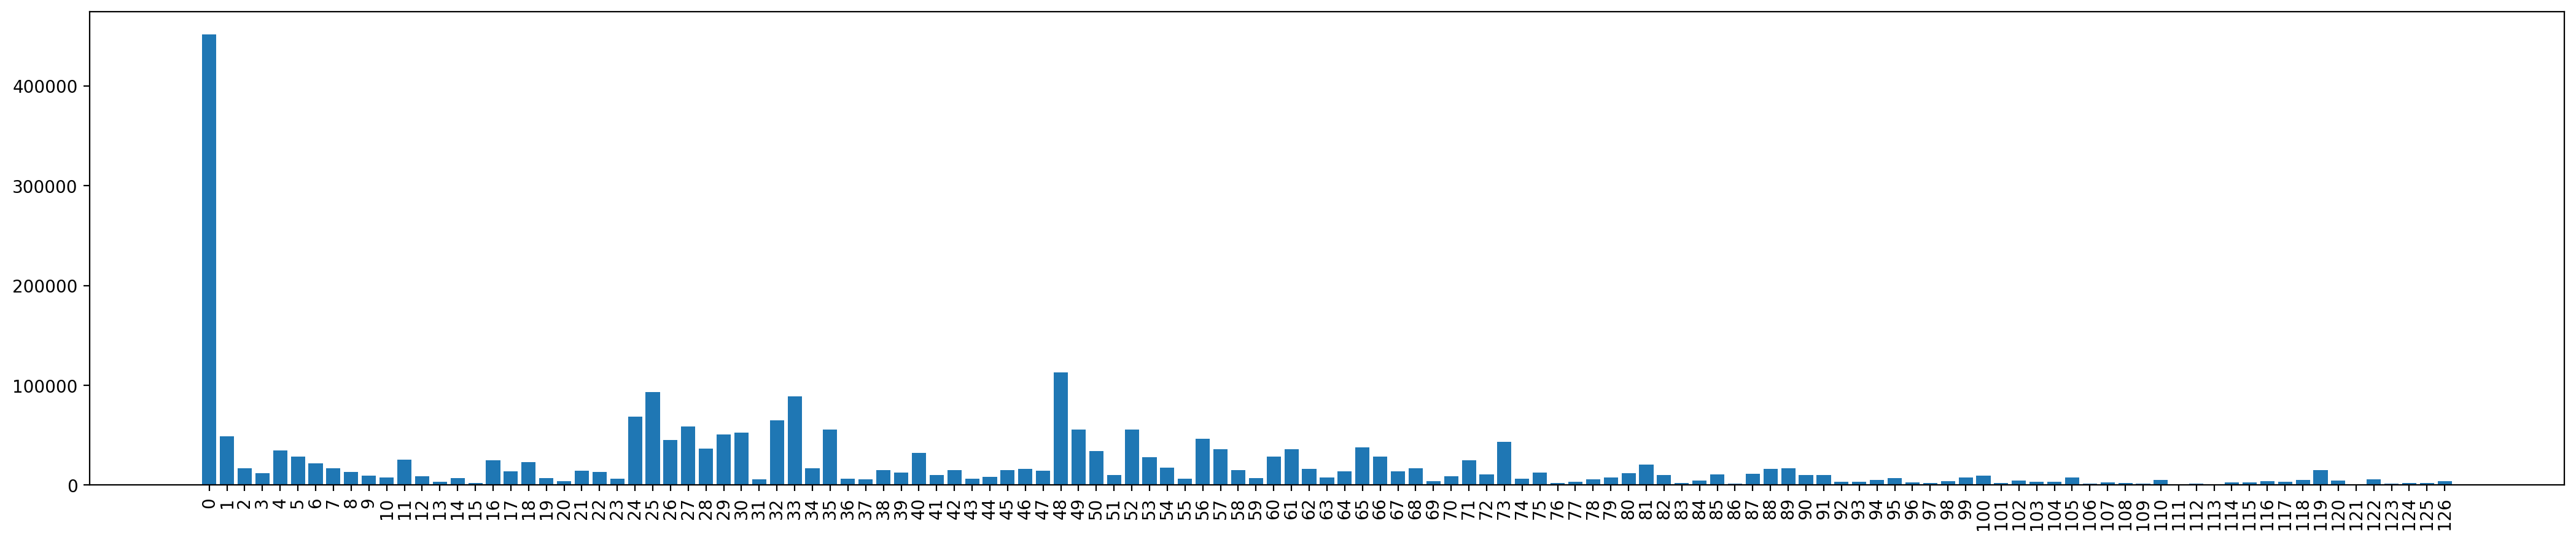

In [208]:
plot_bar_centered(stats["programs"])

The remaining not shown values amount to 0.09% of the total


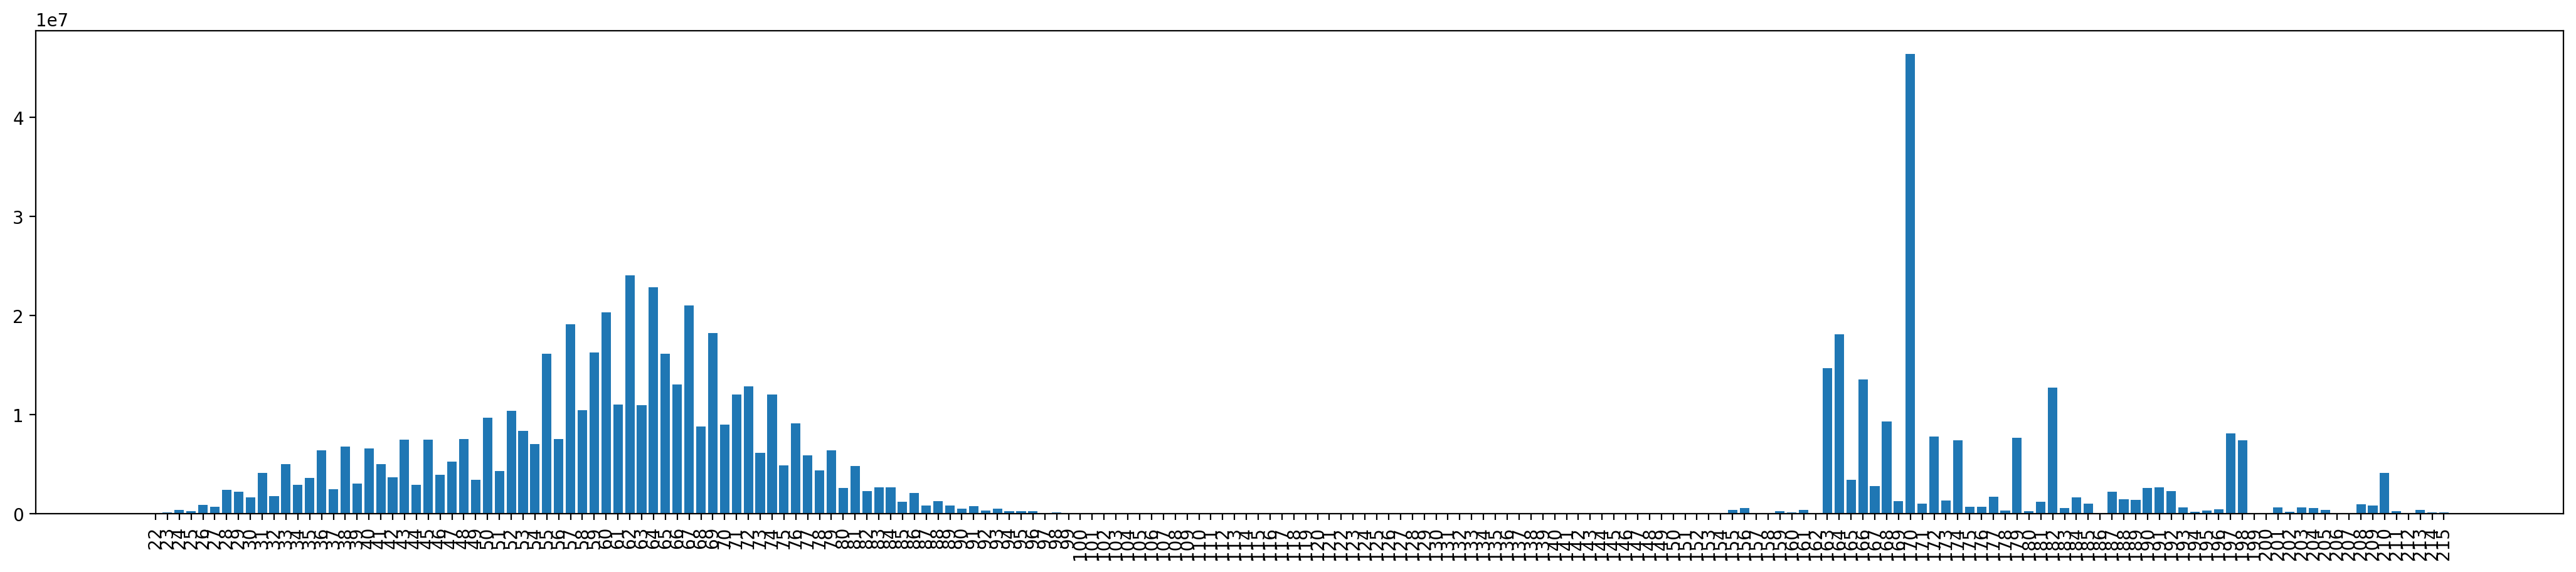

In [209]:
plot_bar_centered(stats["pitch"], lim=[22, 216])

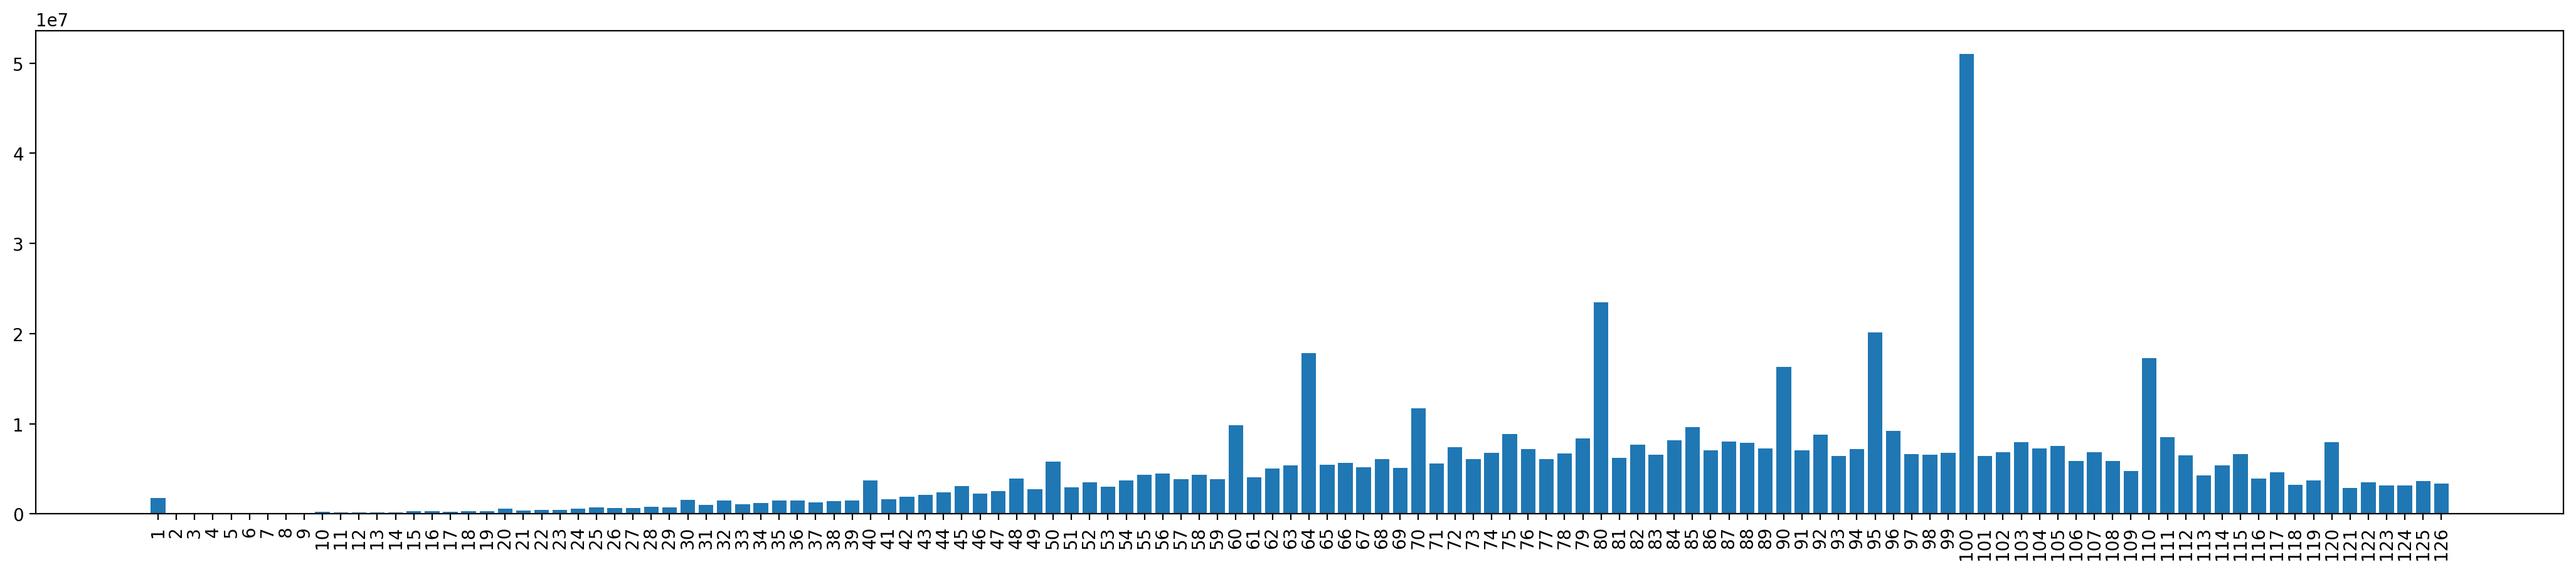

In [210]:
plot_bar_centered(stats["velocity"])

The remaining not shown values amount to 27.85% of the total


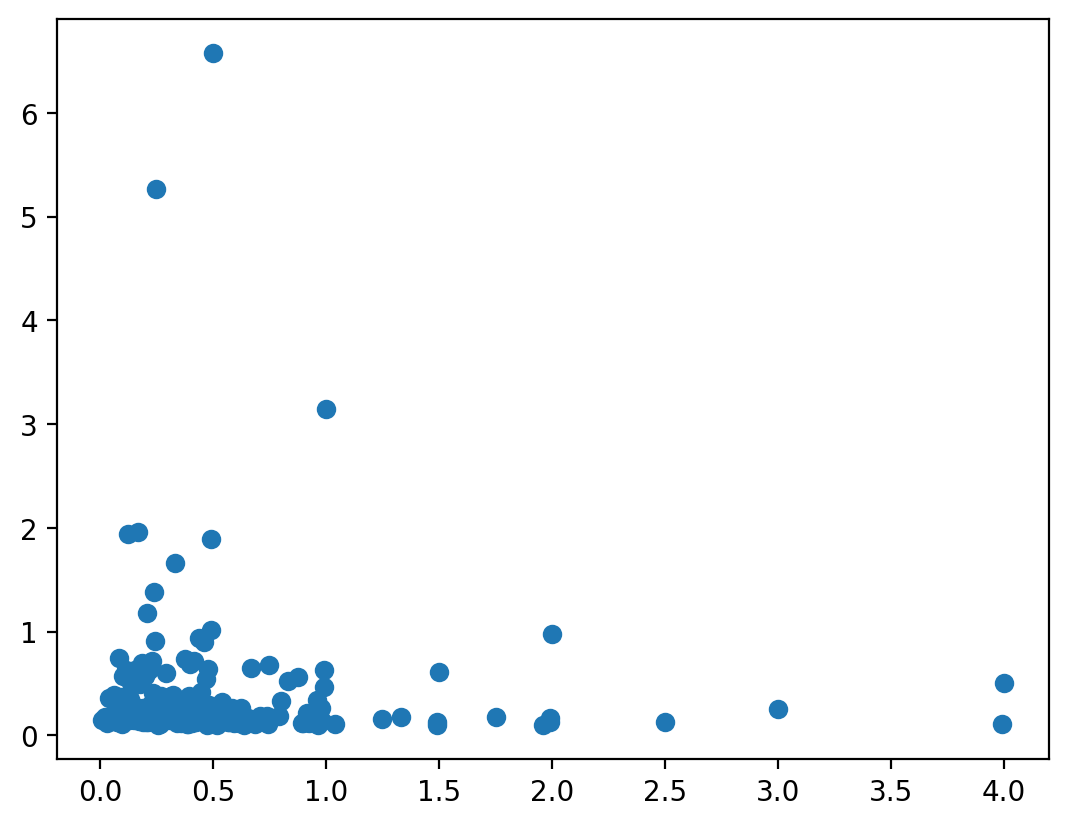

In [288]:
plot_scatter_from_dict(stats["durations"], lim_percentage=1/10)

The remaining not shown values amount to 36.36% of the total


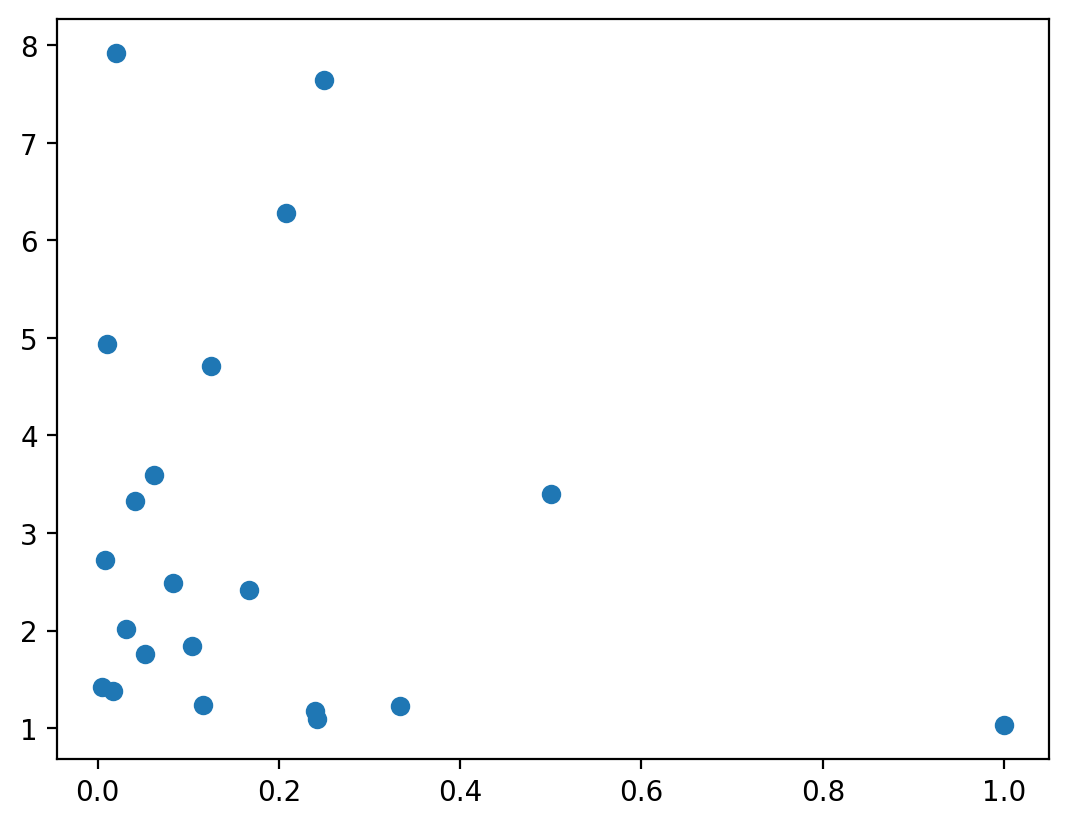

In [286]:
plot_scatter_from_dict(stats["drum_durations"], lim_percentage=1)

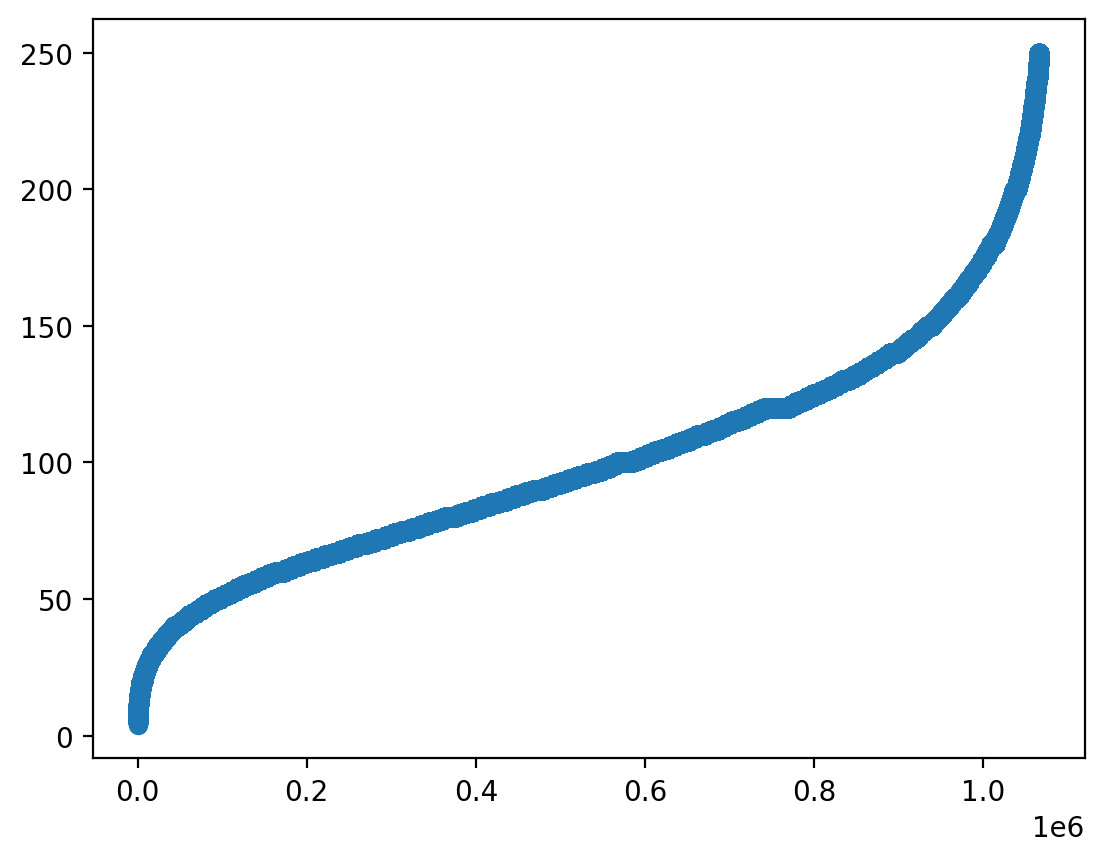

In [226]:
plot_scatter_limit(stats["tempos"], lim=-5000)

The remaining not shown values amount to 0.00% of the total


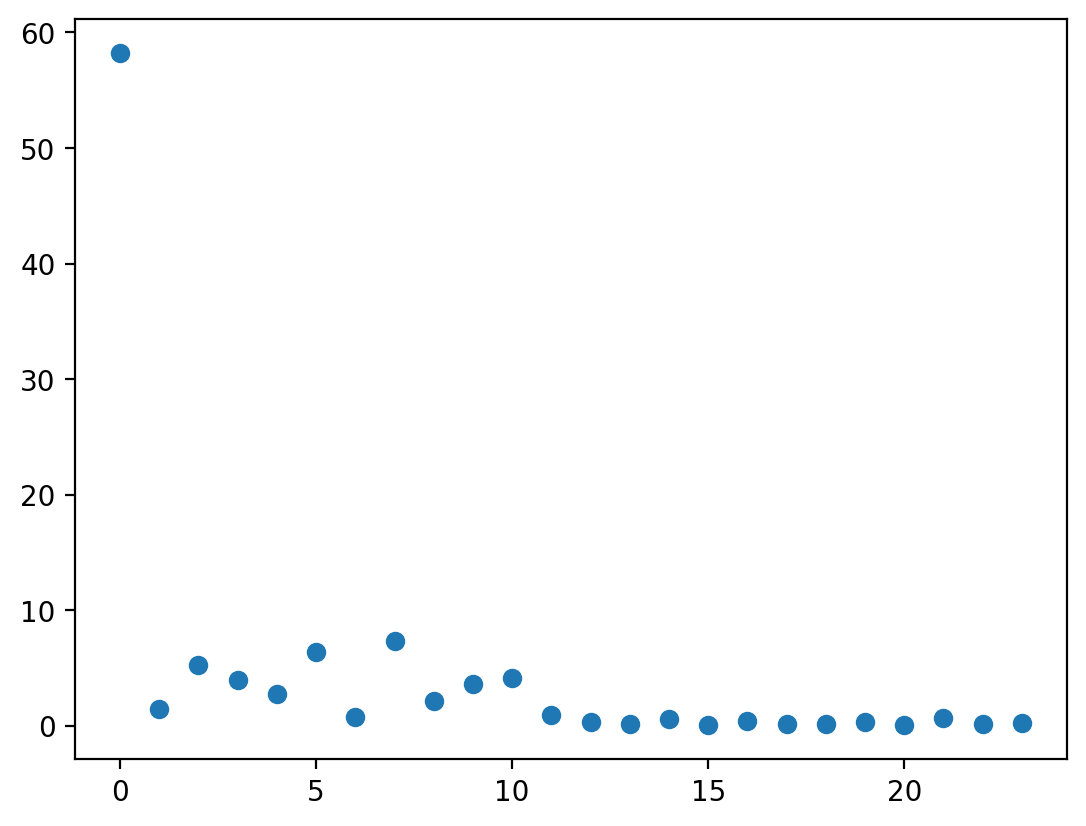

In [237]:
plot_scatter_from_dict(stats["key_signatures"], mapping=utils.key_sign_map)

In [283]:
tot = np.sum(list(stats["time_signatures"].values()))
print(tot)
print()
arr = np.zeros((len(stats["time_signatures"].keys()), 3))

for i, key in enumerate(stats["time_signatures"].keys()):
    arr[i,0] = stats["time_signatures"][key]/tot*100
    arr[i,1] = key[0]
    arr[i,2] = key[1]

arr = arr[arr[:,0].argsort()]

# Numerators
lim_percentage = 0.01
print("The remaining not shown values amount to {:.2f}% of the total".format(sum([x[0] for x in arr if x[0] <= lim_percentage])/sum(arr[:,0])*100))
print(tmp := np.sort(list(set(list([x[1] for x in arr if x[0]>lim_percentage])))))
num_nominators = len(tmp)
print("Total number of accepted numerators {}".format(num_nominators))
print()
# Denominators
lim_percentage = 0.001
print("The remaining not shown values amount to {:.2f}% of the total".format(sum([x[0] for x in arr if x[0] <= lim_percentage])/sum(arr[:,0])*100))
print(tmp := np.sort(list(set(list([x[2] for x in arr if x[0]>lim_percentage])))))
num_denominators = len(tmp)
print("Total number of accepted denominators {}".format(num_denominators))

print("Total possible time_signatures: {}".format(num_nominators*num_denominators))
# for i in arr:
#     print("{:5.2f}%, {:.0f}/{:.0f}".format(i[0], i[1], i[2]))

199440

The remaining not shown values amount to 0.22% of the total
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18. 132.]
Total number of accepted numerators 19

The remaining not shown values amount to 0.02% of the total
[  1.   2.   4.   8.  16.  32.  64. 128.]
Total number of accepted denominators 8
Total possible time_signatures: 152


In [338]:
final_song = []
final_song.append(tuple([0]*11))
final_song

[(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)]

In [330]:
def duration_loss(possible_durations: np.array, real_durations: dict, limit_max_len=1e10) -> float:
    loss = 0
    tot_notes = 0
    for dur, num_notes in real_durations.items():
        if dur < limit_max_len:
            new_val = possible_durations[np.argmin(np.abs(possible_durations - dur))]
            loss += np.abs(new_val - dur) * num_notes
            tot_notes += num_notes

    return loss/tot_notes

In [331]:
np_durations = np.zeros(300)
i = 0
note_l = 1/2

for _ in range(int(256/16)):
    while np_durations[i] < note_l:
        i+=1
        np_durations[i] = np_durations[i-1] + (note_l/32)
    note_l *= 2

np_durations = np_durations[1:129+8]

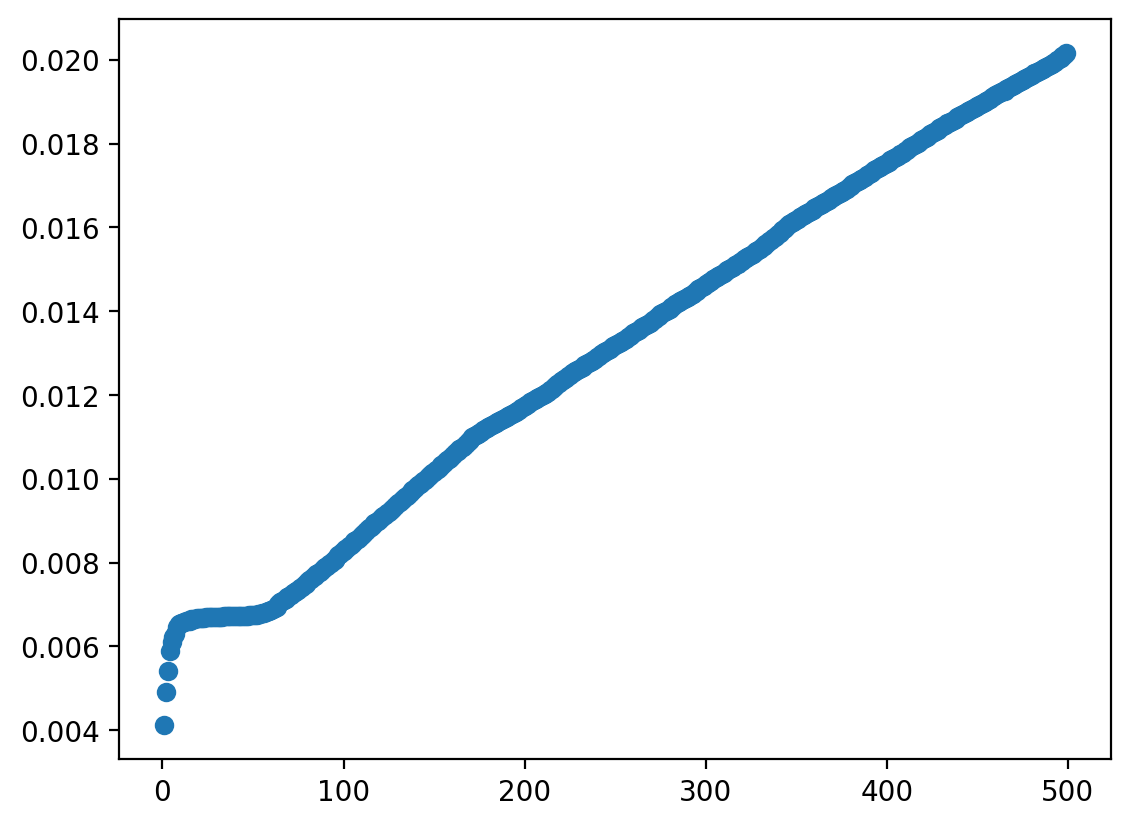

In [332]:
# The mean error with our discretization on "short" (<48 beats) note is 0.67%, if we add long notes it becomes ~2%
plt.scatter(
    range(1,500),
    [duration_loss(np_durations, stats["durations"], limit_max_len=i) for i in range(1,500)]
)

In [333]:
duration_loss(np_durations, stats["durations"], limit_max_len=max(np_durations))

0.006736474747007847